### FIT5149 - Applied Data Analysis - Assignment 2

### INSTALL PACKAGES

In [76]:
# !pip install emoji
#!pip install gensim

    100% |████████████████████████████████| 51kB 1.5MB/s ta 0:00:01
  Stored in directory: /Users/akspikey/Library/Caches/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


### IMPORT PACKAGES

In [36]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import re, string
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import emoji
from sklearn.preprocessing import scale, StandardScaler
import gensim.downloader as api
from nltk.tokenize import TweetTokenizer

### PREPARING THE DATA

In [4]:
train_labels = pd.read_csv("train_labels.csv")
test_data = pd.read_csv("test.csv")

In [5]:
#Encode Labels
le = preprocessing.LabelEncoder()
train_labels['label'] = le.fit_transform(train_labels.gender.values)
train_labels

,id,gender,label
0,d7d392835f50664fc079f0f388e147a0,male,1
1,ee40b86368137b86f51806c9f105b34b,female,0
2,919bc742d9a22d65eab1f52b11656cab,male,1
3,15b97a08d65f22d97ca685686510b6ae,female,0
4,affa98421ef5c46ca7c8f246e0a134c1,female,0
...,...,...,...
3095,97159e619b8d88bdd837f7f7e738de43,male,1
3096,9bccadb3d0033a2b2ad4403184ea72f5,female,0
3097,f252cb406d4c27e71414148175fe6878,female,0
3098,5dcf483c6ceb4cdf9de1648486f28706,female,0


In [6]:
def parse_training_docs(data):
    train_data = data
    for index, row in train_labels.iterrows():
        doc_string = ""
        tree = ET.parse('data/'+row['id']+'.xml')
        document = tree.getroot().find("documents").findall("document")
        for doc in document:
            doc_string = doc_string + " " + doc.text
        train_labels.loc[index,'document'] = doc_string
    return train_data

train_labels = parse_training_docs(train_labels)

In [7]:
train_labels.head()

,id,gender,label,document
0,d7d392835f50664fc079f0f388e147a0,male,1,@CSIFERROSCAN youch! Good things to know! Is ...
1,ee40b86368137b86f51806c9f105b34b,female,0,Donald the Menace #ThanksComey https://t.co/...
2,919bc742d9a22d65eab1f52b11656cab,male,1,This seems super sketch / too good to be true...
3,15b97a08d65f22d97ca685686510b6ae,female,0,Just some texts with my dad about our Saturda...
4,affa98421ef5c46ca7c8f246e0a134c1,female,0,Irrevocably love this talented human and so p...


In [8]:
train_labels.iloc[0]["document"][1000:]

's at the Aus Open. Latecomers better get in quick, Fed’s up 5-0 already in 13 mins 😳 What makes this horse shit weather worse is watching the Aus Open with Melbourne bathed in sunshine 😫 #Summer2017 @ThornhillDave So do you want this now for your birthday instead of the Miranda Sex Arse? @ThornhillDave What weatherbomb??! https://t.co/VC93gMCzK5 So *someone* thought it was a good idea to tackle the weather bomb this morning… https://t.co/nc34ECgsiA Back to the grind tomorrow. Having successfully only worn them 3 times since Christmas, wearing socks is going to be the biggest shock! @SKYNZ WiFi on iPad Pro &amp; iPad Air. iPhone actually works fine. @SKYNZ Any issues with SKYGO app? Getting this on multiple devices https://t.co/a2xKZZESXp @justin_lester Just tell them you know someone who knows the mayor… @justin_lester Make sure you add the hashtag #NBAVote 😉 @RealStevenAdams Damn. Last 2 points for @RealStevenAdams cost me at the TAB! #NBAVote https://t.co/2RnwfinC8z @Timely Nice! So

In [9]:
import re, string
def clean_documents(document):
    # Remove square brackets characters
#     document = re.sub(r'\[.*?\]', '', document)
    #Remove URL
    document = re.sub(r'http\S+', '', document)
    #Remove user mentions
    document = re.sub(r"@(\w+)", ' ', document, flags=re.MULTILINE)
    #Remove punctuations
    document = re.sub(r'[%s]' % re.escape(string.punctuation), '', document)
    #Remove words with numbers
    document = re.sub(r'\w*\d\w*', '', document)  
    #Remove triple dots
    document = document.replace("…", " ")
    #Remove Quotes
    document = document.replace("'", "")
    document = document.replace("\"", "")
    document = document.replace("’", "")
    document = document.replace("“", "")
    document = document.replace("”", "")
    #convert to lowercase
    document = document.lower()
    return document
train_labels['document'] = train_labels['document'].apply(lambda doc: clean_documents(doc))
# train_labels["document"].values.tolist()

In [10]:
train_data, validation_data = train_test_split(train_labels, test_size=0.2, random_state=100)

In [11]:
print("The number of Training documents are: ", len(train_data))
print("The number of Validation documents are: ", len(validation_data))

The number of Training documents are:  2480
The number of Validation documents are:  620


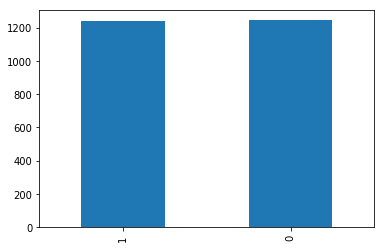

In [13]:
from matplotlib import pyplot as plt
train_data.label.value_counts().sort_index(ascending=False).plot(kind='bar')
plt.show()

In [14]:
def tokenize_and_lemmatize(doc):
    stopwords_list = stopwords.words('english')
    wnl = WordNetLemmatizer()
    tknzr = TweetTokenizer()
    doc = tknzr.tokenize(doc)
    doc = [ wnl.lemmatize(token) for token in doc if token not in stopwords_list and len(token) > 0]
    doc = [ token for token in doc if len(token) > 1 or token in emoji.UNICODE_EMOJI.keys()]
    return doc

In [15]:
train_docs = [tokenize_and_lemmatize(doc) for doc in train_data["document"] .tolist()]
train_labels = train_data["label"].tolist()

validation_docs = [tokenize_and_lemmatize(doc) for doc in validation_data["document"] .tolist()]
validation_labels = validation_data["label"].tolist()

In [16]:
train_docs[0]

['sound',
 'cool',
 'eh',
 'younguns',
 'fashionable',
 'language',
 'lady',
 'sewing',
 'circle',
 'shall',
 'hear',
 'amp',
 'loved',
 '😀',
 'wardinibooks',
 'wonder',
 'could',
 'maybe',
 'shit',
 'got',
 'real',
 'finished',
 'yr',
 'book',
 'sitting',
 'wonderful',
 'amp',
 'powerful',
 'stuff',
 'please',
 'write',
 'chris',
 'round',
 'good',
 'guy',
 'tragedy',
 'lol',
 'realized',
 'new',
 'handlefacepalm',
 'napier',
 'north',
 'island',
 'brings',
 'welcome',
 'nz',
 'fun',
 'drink',
 'wine',
 'amp',
 'dont',
 'mind',
 'earthquake',
 '😀',
 'cheer',
 'lynz',
 '😀',
 'always',
 'fun',
 'taken',
 'phd',
 'level',
 'beautiful',
 '😌',
 'agree',
 'thank',
 'gah',
 'end',
 'well',
 'put',
 'salute',
 'roger',
 'sir',
 'stand',
 'easy',
 'till',
 'well',
 'done',
 'kokako',
 'sad',
 'lovely',
 'shore',
 'plover',
 '😢',
 'learningcurve',
 'bro',
 'legend',
 'also',
 'beer',
 'good',
 'replacement',
 'fluid',
 'sport',
 'wonder',
 'voted',
 'boty',
 'yet',
 'shore',
 'plover',
 'win',


### FEATURE EXTRACTION

#### TFID VECTORIZER

In [17]:
def dummy_fun(doc):
    return doc


vectorizer = TfidfVectorizer(
    analyzer='word',
    input='content',
    token_pattern=r'[^\s]+',
    min_df = 15,
    max_df=0.9,
    tokenizer=dummy_fun,
    preprocessor=dummy_fun) 

In [18]:
x_train_tfidf=vectorizer.fit_transform(train_docs)
y_train_tfidf=np.asarray(train_labels)

x_valid_tfidf=vectorizer.transform(validation_docs)
y_valid_tfidf=np.asarray(validation_labels)

In [19]:
vectorizer.get_feature_names()

['aa',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abbott',
 'abc',
 'aberdeen',
 'ability',
 'able',
 'aboard',
 'aboriginal',
 'abortion',
 'abroad',
 'absence',
 'absolute',
 'absolutely',
 'abstract',
 'absurd',
 'abt',
 'abuse',
 'abused',
 'abuser',
 'abusive',
 'ac',
 'aca',
 'academic',
 'academy',
 'acc',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accessibility',
 'accessible',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accommodation',
 'accomplish',
 'accomplished',
 'accomplishment',
 'according',
 'account',
 'accountability',
 'accountable',
 'acct',
 'accuracy',
 'accurate',
 'accurately',
 'accusation',
 'accused',
 'ace',
 'ache',
 'achieve',
 'achieved',
 'achievement',
 'achieving',
 'acid',
 'acknowledge',
 'aclu',
 'acoustic',
 'acquired',
 'acquisition',
 'across',
 'act',
 'acting',
 'action',
 'active',
 'actively',
 'activism',
 'activist',
 'activity',
 'actor',
 'actress',
 'actual',
 'actuall

In [20]:
#Top 10 Words in Feature
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(x_train_tfidf.toarray()).flatten()[::-1]

n = 1000
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['amp', 'bought', 'smell', 'whisky', 'ive', 'daughter', 'got',
       'spotify', 'locked', 'like', 'wash', 'accidentally', 'feel',
       'crack', 'trying', 'ending', 'direction', 'much', 'putin',
       'computer', 'room', 'checked', 'im', 'hahaha', 'shoe', 'worth',
       'eh', 'russian', 'stuff', 'know', 'something', 'good', 'album',
       'leg', 'wife', 'sad', 'sell', 'great', 'quality', 'terrible',
       'wellington', 'site', 'sort', 'let', 'go', 'following', 'nz',
       'cursed', 'rear', 'amanda', 'crashing', 'accidental', 'glowing',
       'blue', 'dont', 'infinite', 'clicked', 'suited', 'rug', 'dumbest',
       'usage', 'who', 'thee', 'yet', 'filthy', 'come', 'day', 'change',
       'correlation', 'trusting', 'parrot', 'away', 'googling', 'opener',
       'sting', 'thats', 'chrome', 'folder', 'smack', 'pirate', 'maximum',
       'donkey', 'oddly', 'passive', 'daylight', 'oxford', 'handing',
       'luggage', 'end', 'stitch', 'paranoid', 'rome', 'tshirts', 'dream',
    

### PRETRAINED GLOVE EMBEDDINGS

In [62]:
training_docs = train_docs.copy()
#generate bigrams
from gensim.models import Phrases
bigram = Phrases(training_docs, min_count=40)
for idx in range(len(training_docs)):
    for token in bigram[training_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            training_docs[idx].append(token)
training_docs[0]

KeyboardInterrupt: 

In [21]:
#Pretained glove embeddings
vocab = []
E = {}
with open("glove/glove.twitter.27B.200d.txt", "r", encoding="utf8") as lines:
    for i, line in enumerate(lines):
        l = line.split(' ')
        if l[0].isalpha():
            v = [float(i) for i in l[1:]]
            E[l[0]] = np.array(v)
            vocab.append(l[0])

In [22]:
def doc_mean(doc):
    return np.mean(np.array(
        [E[w.lower().strip()] for w in doc if w.lower().strip() in E]), axis=0
            )

In [23]:
def transform(docs):
        return np.array([doc_mean(doc) for doc in docs])

In [24]:
training_docs = train_docs.copy()
validation_data = validation_docs.copy()
x_train = transform(training_docs)
x_valid = transform(validation_data)

In [25]:
x_train.shape

(2480, 200)

In [26]:
x_valid.shape

(620, 200)

In [27]:
x_train_w2vec = scale(x_train)
x_valid_w2vec = scale(x_valid)

In [28]:
y_train_w2vec =np.asarray(train_labels)
y_valid_w2vec = np.asarray(validation_labels)

### LOGISTIC REGRESSION WITH TFIDF

In [170]:
logistic_regression_model = LogisticRegression(max_iter=7500)

CV = 10
cv_df = pd.DataFrame(index=range(CV * 1))
entries = []

model_name = logistic_regression_model.__class__.__name__
accuracies = cross_val_score(logistic_regression_model, x_train_tfidf, y_train_tfidf, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.802419
1,LogisticRegression,1,0.822581
2,LogisticRegression,2,0.778226
3,LogisticRegression,3,0.814516
4,LogisticRegression,4,0.754032
5,LogisticRegression,5,0.794355
6,LogisticRegression,6,0.838710
7,LogisticRegression,7,0.818548
8,LogisticRegression,8,0.774194
9,LogisticRegression,9,0.774194


In [171]:
#Measure performance on validation data
logistic_regression_model.fit(x_train_tfidf, y_train_tfidf)
print(model_name)
# Do the prediction
y_predict_tfidf=logistic_regression_model.predict(x_valid_tfidf)
print(confusion_matrix(y_valid_tfidf,y_predict_tfidf))
recall=recall_score(y_valid_tfidf,y_predict_tfidf,average='macro')
precision=precision_score(y_valid_tfidf,y_predict_tfidf,average='macro')
f1score=f1_score(y_valid_tfidf,y_predict_tfidf,average='macro')
accuracy=accuracy_score(y_valid_tfidf,y_predict_tfidf)
matthews = matthews_corrcoef(y_valid_tfidf,y_predict_tfidf) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

LogisticRegression
[[228  77]
 [ 52 263]]
Accuracy: 0.7919354838709678
Macro Precision: 0.7939075630252102
Macro Recall: 0.7912308092635962
Macro F1 score:0.7912703073008416
MCC:0.5851322497641822


### LOGISTIC WITH GLOVE EMBEDDINGS

In [167]:
logistic_regression_model_glove = LogisticRegression(max_iter=7500)

CV = 10
cv_df = pd.DataFrame(index=range(CV * 1))
entries = []

model_name = logistic_regression_model_glove.__class__.__name__
accuracies = cross_val_score(logistic_regression_model_glove, x_train_w2vec, y_train_w2vec, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.766129
1,LogisticRegression,1,0.814516
2,LogisticRegression,2,0.786290
3,LogisticRegression,3,0.802419
4,LogisticRegression,4,0.721774
5,LogisticRegression,5,0.745968
6,LogisticRegression,6,0.842742
7,LogisticRegression,7,0.798387
8,LogisticRegression,8,0.790323
9,LogisticRegression,9,0.790323


In [172]:
#Measure performance on validation data
logistic_regression_model_glove.fit(x_train_w2vec, y_train_w2vec)
print(model_name)
# Do the prediction
y_predict_w2vec=logistic_regression_model_glove.predict(x_valid_w2vec)
print(confusion_matrix(y_valid_w2vec,y_predict_w2vec))
recall=recall_score(y_valid_w2vec,y_predict_w2vec,average='macro')
precision=precision_score(y_valid_w2vec,y_predict_w2vec,average='macro')
f1score=f1_score(y_valid_w2vec,y_predict_w2vec,average='macro')
accuracy=accuracy_score(y_valid_w2vec,y_predict_w2vec)
matthews = matthews_corrcoef(y_valid_w2vec,y_predict_w2vec) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

LogisticRegression
[[240  65]
 [ 62 253]]
Accuracy: 0.7951612903225806
Macro Precision: 0.7951497355158482
Macro Recall: 0.7950299245381213
Macro F1 score:0.795071194151435
MCC:0.5901796478926976


### NAIVE BAYES CLASSIFIER

In [163]:
naive_bayes_classifier = MultinomialNB()

CV = 10
cv_df = pd.DataFrame(index=range(CV * 1))
entries = []

model_name = naive_bayes_classifier.__class__.__name__
accuracies = cross_val_score(naive_bayes_classifier, x_train_tfidf, y_train_tfidf, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,MultinomialNB,0,0.762097
1,MultinomialNB,1,0.762097
2,MultinomialNB,2,0.762097
3,MultinomialNB,3,0.790323
4,MultinomialNB,4,0.685484
5,MultinomialNB,5,0.766129
6,MultinomialNB,6,0.733871
7,MultinomialNB,7,0.778226
8,MultinomialNB,8,0.754032
9,MultinomialNB,9,0.725806


In [165]:
#Measure performance on validation data
naive_bayes_classifier.fit(x_train_tfidf, y_train_tfidf)
print(model_name)
# Do the prediction
y_predict_tfidf=naive_bayes_classifier.predict(x_valid_tfidf)
print(confusion_matrix(y_valid_tfidf,y_predict_tfidf))
recall=recall_score(y_valid_tfidf,y_predict_tfidf,average='macro')
precision=precision_score(y_valid_tfidf,y_predict_tfidf,average='macro')
f1score=f1_score(y_valid_tfidf,y_predict_tfidf,average='macro')
accuracy=accuracy_score(y_valid_tfidf,y_predict_tfidf)
matthews = matthews_corrcoef(y_valid_tfidf,y_predict_tfidf) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

MultinomialNB
[[230  75]
 [ 74 241]]
Accuracy: 0.7596774193548387
Macro Precision: 0.7596185876082611
Macro Recall: 0.7595888628675513
Macro F1 score:0.7596017476885283
MCC:0.5192074496249386


### RANDOM FOREST

In [103]:
random_forest_classifier = RandomForestClassifier(max_depth=5, random_state=0)

CV = 10
cv_df = pd.DataFrame(index=range(CV * 1))
entries = []

model_name = random_forest_classifier.__class__.__name__
accuracies = cross_val_score(random_forest_classifier, x_train_w2vec, y_train_w2vec, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.758065
1,RandomForestClassifier,1,0.745968
2,RandomForestClassifier,2,0.758065
3,RandomForestClassifier,3,0.770161
4,RandomForestClassifier,4,0.681452
5,RandomForestClassifier,5,0.750000
6,RandomForestClassifier,6,0.778226
7,RandomForestClassifier,7,0.786290
8,RandomForestClassifier,8,0.750000
9,RandomForestClassifier,9,0.713710


In [104]:
#Measure performance on validation data
random_forest_classifier.fit(x_train_w2vec, y_train_w2vec)
print(model_name)
# Do the prediction
y_predict_w2vec=random_forest_classifier.predict(x_valid_w2vec)
print(confusion_matrix(y_valid_w2vec,y_predict_w2vec))
recall=recall_score(y_valid_w2vec,y_predict_w2vec,average='macro')
precision=precision_score(y_valid_w2vec,y_predict_w2vec,average='macro')
f1score=f1_score(y_valid_w2vec,y_predict_w2vec,average='macro')
accuracy=accuracy_score(y_valid_w2vec,y_predict_w2vec)
matthews = matthews_corrcoef(y_valid_w2vec,y_predict_w2vec) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

RandomForestClassifier
[[213  92]
 [ 64 251]]
Accuracy: 0.7483870967741936
Macro Precision: 0.7503657471240173
Macro Recall: 0.7475930262815509
Macro F1 score:0.7474383480086485
MCC:0.49795105385038363


### SUPPORT VECTOR MACHINES WITH GLOVE EMBEDDINGS

In [38]:
svm_classifier = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

CV = 10
cv_df = pd.DataFrame(index=range(CV * 1))
entries = []

model_name = svm_classifier.__class__.__name__
accuracies = cross_val_score(svm_classifier, x_train_w2vec, y_train_w2vec, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,SVC,0,0.794355
1,SVC,1,0.806452
2,SVC,2,0.810484
3,SVC,3,0.798387
4,SVC,4,0.758065
5,SVC,5,0.766129
6,SVC,6,0.846774
7,SVC,7,0.826613
8,SVC,8,0.822581
9,SVC,9,0.778226


In [39]:
#Measure performance on validation data
svm_classifier.fit(x_train_w2vec, y_train_w2vec)
print(model_name)
# Do the prediction
y_predict_w2vec=svm_classifier.predict(x_valid_w2vec)
print(confusion_matrix(y_valid_w2vec,y_predict_w2vec))
recall=recall_score(y_valid_w2vec,y_predict_w2vec,average='macro')
precision=precision_score(y_valid_w2vec,y_predict_w2vec,average='macro')
f1score=f1_score(y_valid_w2vec,y_predict_w2vec,average='macro')
accuracy=accuracy_score(y_valid_w2vec,y_predict_w2vec)
matthews = matthews_corrcoef(y_valid_w2vec,y_predict_w2vec) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

SVC
[[241  64]
 [ 56 259]]
Accuracy: 0.8064516129032258
Macro Precision: 0.8066526982935651
Macro Recall: 0.8061930783242258
Macro F1 score:0.8062883387662858
MCC:0.6128456042656644


### Multilayer Perceptron

In [31]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=300,  solver='adam',  activation='relu', hidden_layer_sizes=(126, ), learning_rate_init=0.001)

CV = 10
cv_df = pd.DataFrame(index=range(CV * 1))
entries = []

model_name = mlp_classifier.__class__.__name__
accuracies = cross_val_score(mlp_classifier, x_train_w2vec, y_train_w2vec, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,MLPClassifier,0,0.782258
1,MLPClassifier,1,0.786290
2,MLPClassifier,2,0.798387
3,MLPClassifier,3,0.806452
4,MLPClassifier,4,0.733871
5,MLPClassifier,5,0.737903
6,MLPClassifier,6,0.810484
7,MLPClassifier,7,0.782258
8,MLPClassifier,8,0.774194
9,MLPClassifier,9,0.782258


In [33]:
#Measure performance on validation data
mlp_classifier.fit(x_train_w2vec, y_train_w2vec)
print(model_name)
# Do the prediction
y_predict_w2vec=mlp_classifier.predict(x_valid_w2vec)
print(confusion_matrix(y_valid_w2vec,y_predict_w2vec))
recall=recall_score(y_valid_w2vec,y_predict_w2vec,average='macro')
precision=precision_score(y_valid_w2vec,y_predict_w2vec,average='macro')
f1score=f1_score(y_valid_w2vec,y_predict_w2vec,average='macro')
accuracy=accuracy_score(y_valid_w2vec,y_predict_w2vec)
matthews = matthews_corrcoef(y_valid_w2vec,y_predict_w2vec) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

MLPClassifier
[[247  58]
 [ 62 253]]
Accuracy: 0.8064516129032258
Macro Precision: 0.8064287869800935
Macro Recall: 0.8065053343741868
Macro F1 score:0.8064334849257475
MCC:0.6129341165743999


### Stacked Classifier

In [40]:
clf1 = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
clf2 = RandomForestClassifier(max_depth=5, random_state=0)
clf3 = MLPClassifier(random_state=1, max_iter=300,  solver='adam',  activation='relu', hidden_layer_sizes=(126, ), learning_rate_init=0.001)
lr = LogisticRegression()


base_learners = [
                    ('clf1', SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')),
#                     ('clf2', RandomForestClassifier(max_depth=5, random_state=0)),
                    ('clf3', MLPClassifier(random_state=1, max_iter=300,  solver='adam',  activation='relu', hidden_layer_sizes=(126, ), learning_rate_init=0.001))
                ]

sclf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

model_name = sclf.__class__.__name__
accuracies = cross_val_score(sclf, x_train_w2vec, y_train_w2vec, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df

,model_name,fold_idx,accuracy
0,MLPClassifier,0,0.782258
1,MLPClassifier,1,0.786290
2,MLPClassifier,2,0.798387
3,MLPClassifier,3,0.806452
4,MLPClassifier,4,0.733871
5,MLPClassifier,5,0.737903
6,MLPClassifier,6,0.810484
7,MLPClassifier,7,0.782258
8,MLPClassifier,8,0.774194
9,MLPClassifier,9,0.782258


In [41]:
#Measure performance on validation data
sclf.fit(x_train_w2vec, y_train_w2vec)
print(model_name)
# Do the prediction
y_predict_w2vec=sclf.predict(x_valid_w2vec)
print(confusion_matrix(y_valid_w2vec,y_predict_w2vec))
recall=recall_score(y_valid_w2vec,y_predict_w2vec,average='macro')
precision=precision_score(y_valid_w2vec,y_predict_w2vec,average='macro')
f1score=f1_score(y_valid_w2vec,y_predict_w2vec,average='macro')
accuracy=accuracy_score(y_valid_w2vec,y_predict_w2vec)
matthews = matthews_corrcoef(y_valid_w2vec,y_predict_w2vec) 
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))
print('MCC:'+ str(matthews))

StackingClassifier
[[243  62]
 [ 57 258]]
Accuracy: 0.8080645161290323
Macro Precision: 0.808125
Macro Recall: 0.8078844652615145
Macro F1 score:0.8079521051604086
MCC:0.6160094183004158
